# Graph Classification with Graph Neural Networks 

From (https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=N-FO5xL3mw98)

In this tutorial session we will have a closer look at how to apply Graph Neural Networks (GNNs) to the task of graph classification. Graph classification refers to the problem of classifiying entire graphs (in contrast to nodes), given a dataset of graphs, based on some structural graph properties. Here, we want to embed entire graphs, and we want to embed those graphs in such a way so that they are linearly separable given a task at hand. We will train the model and then analyze its loss landscape after.

In [1]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root="data/TUDataset", name="MUTAG")

In [2]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

In [3]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, d):
        x, edge_index, batch = d
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x


model = GCN(hidden_channels=64)

In [5]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()


def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model((data.x, data.edge_index, data.batch))  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.


def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model((data.x, data.edge_index, data.batch))
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)

In [6]:
PATH = "./gcn.pth"
torch.save(model.state_dict(), PATH)

In [7]:
model = GCN(hidden_channels=64)
model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

## Generate loss landscape

In [8]:
from landscaper import LossLandscape, PyHessian

In [9]:
test_in = []
test_lbl = []
for data in test_loader:
    d = (data.x, data.edge_index, data.batch)
    y = data.y
    test_in.append(d)
    test_lbl.append(y)
    
data = list(zip(test_in, test_lbl))

In [13]:
from collections.abc import Generator

from landscaper.utils import DeviceStr


def gnn_generator(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    data: torch.utils.data.DataLoader,
    device: DeviceStr,
) -> Generator[tuple[int, torch.nn.Module], None, None]:
    """Calculates the per-sample gradient for most PyTorch Geometric models that implement `backward`.

    Args:
        model (torch.nn.Module): The model to calculate per-sample gradients for.
        criterion (torch.nn.Module): Function that calculates the loss for the model.
        data (torch.utils.data.DataLoader): Source of data for the model.
        device (DeviceStr): Device used for pyTorch calculations.

    Yields:
        The size of the current input (int) and the model.
    """
    params = [p for p in model.parameters() if p.requires_grad]
    for inputs, targets in data:
        model.zero_grad()  # clear gradients
        input_size = len(inputs[0])  # assuming inputs is a tuple of (x, edge_index, batch)

        inputs = (inputs[0].to(device), inputs[1].to(device), inputs[2].to(device))  # move inputs to device
        outputs = model(inputs)
        loss = criterion(outputs, targets.to(device))
        grads = torch.autograd.grad(
            loss, params, create_graph=True, materialize_grads=True
        )
        yield input_size, grads

In [14]:
hessian_comp = PyHessian(model, criterion, data, "cpu", hessian_generator=gnn_generator)

In [15]:
evals, evecs = hessian_comp.eigenvalues(top_n=3)

Err: 0.0002508581697236493:   6%|██▊                                           | 6/100 [00:00<00:01, 86.92it/s]

Eigenvectors computed: 100%|█████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.20it/s]


In [17]:
def loss_function(mdl, data):
    batch_loss = 0
    for d in data:
        tt, lbl_t = d
        output = model.forward(tt)
        loss = criterion(output, lbl_t)
        batch_loss += loss
    return batch_loss

In [18]:
with torch.backends.cudnn.flags(enabled=False):
    landscape = LossLandscape.compute(
        model,
        data,
        evecs,
        loss_function,  # loss function
        dim=2,
        distance=0.01,
        device="cpu",
    )

Computing 1681 points in 2D space...


Computing 2D landscape: 100%|█████████████████████████████████████████████| 1681/1681 [00:03<00:00, 441.97it/s]

Loss hypercube stats - min: 0.5090966820716858, max: 0.5779156684875488, mean: 0.524149081807701


In [19]:
landscape.save("gnn.npz")

In [20]:
landscape = LossLandscape.load_from_npz("gnn.npz")

Attempting log-scale surface plot...


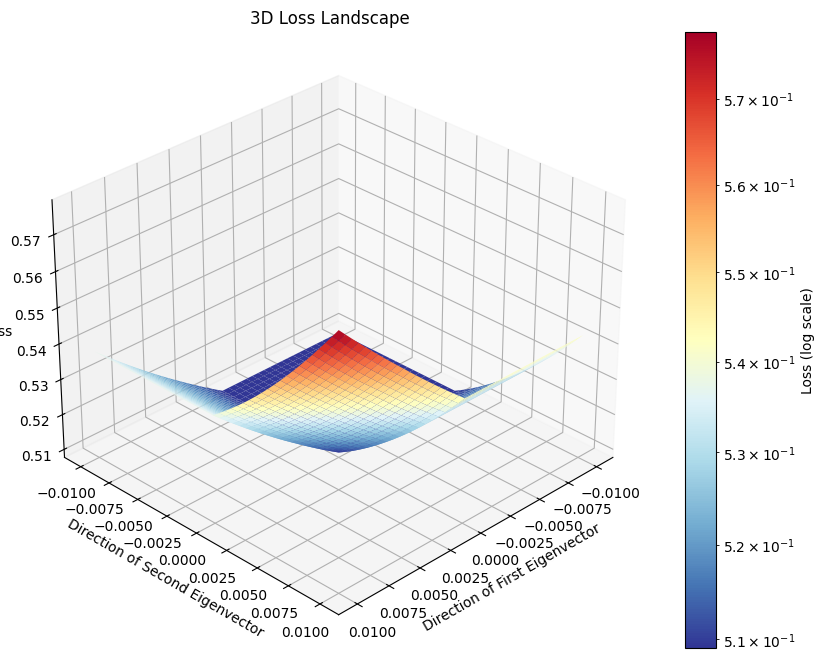

In [21]:
landscape.show()

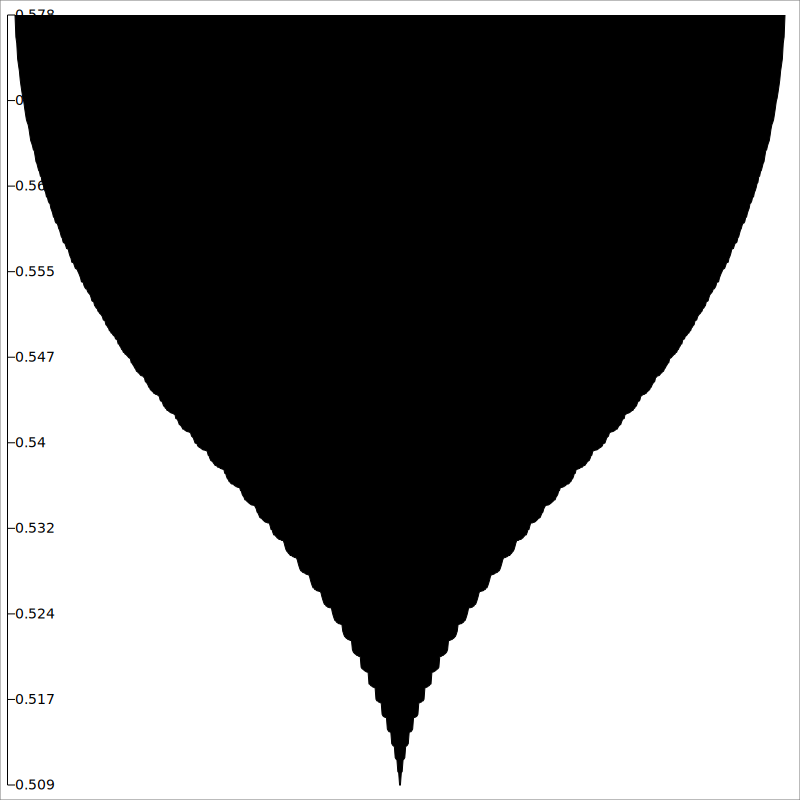

In [22]:
landscape.show_profile()

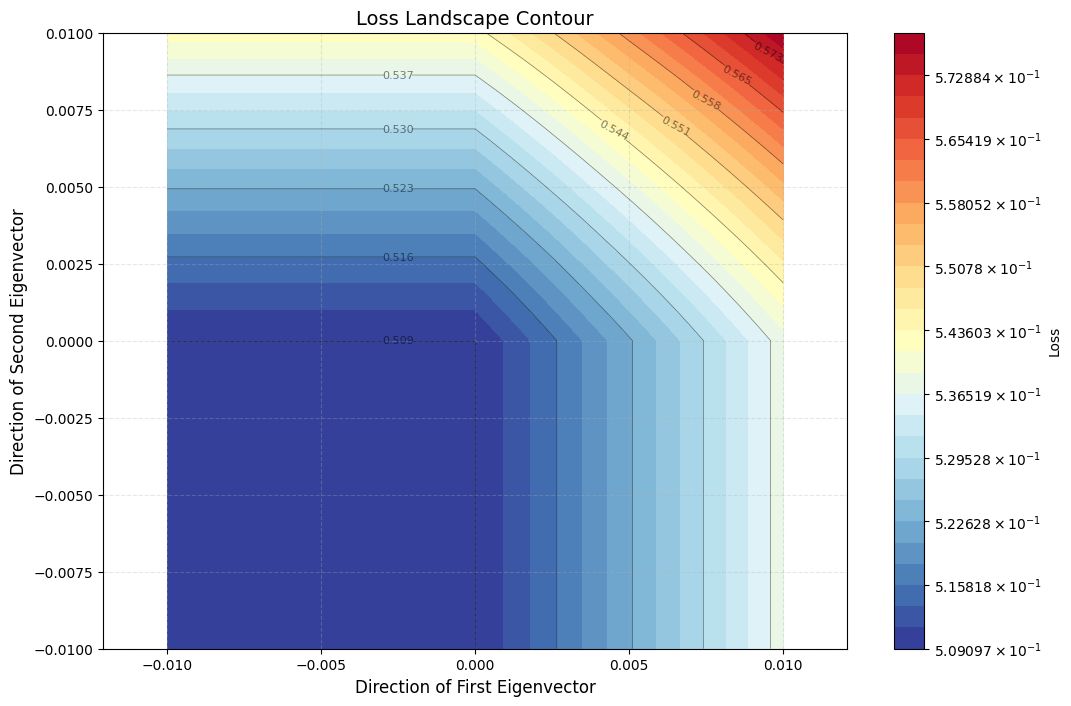

In [23]:
landscape.show_contour()

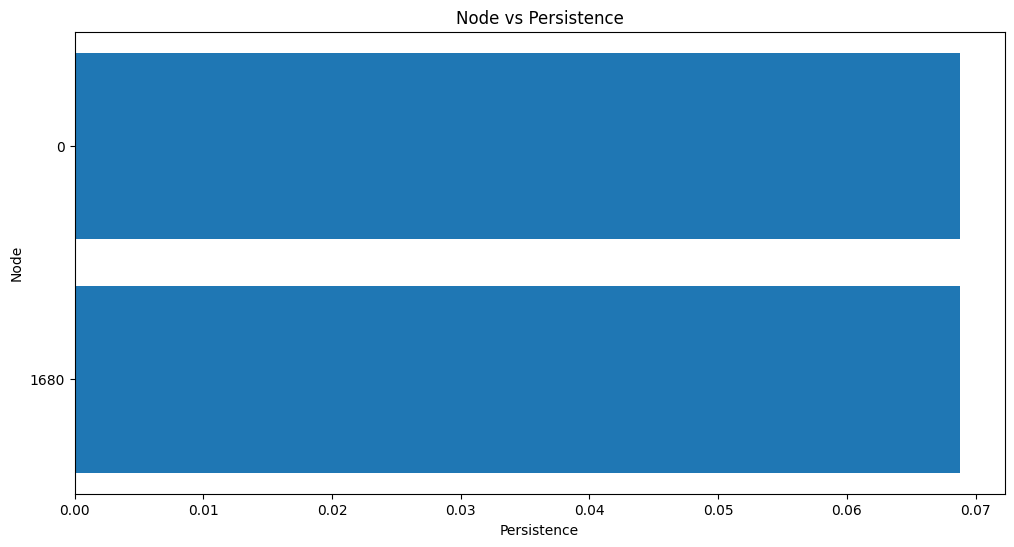

In [24]:
landscape.show_persistence_barcode()

In [25]:
# we can use this function to convert the merge tree
# into a networkx graph and visualize it!
from landscaper.tda import merge_tree_to_nx

g = merge_tree_to_nx(landscape.get_sublevel_tree())

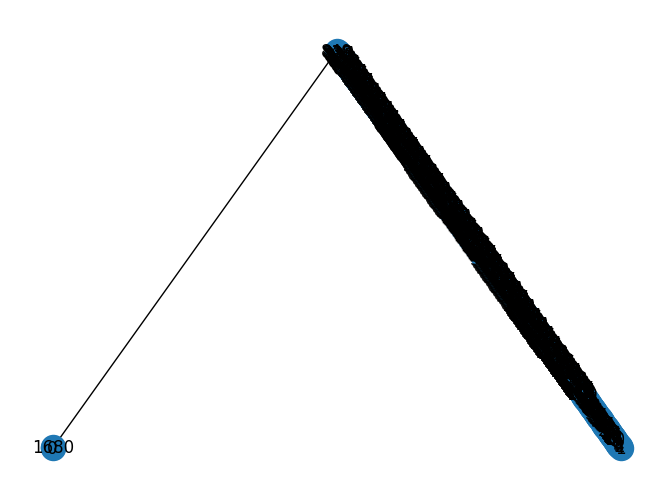

In [26]:
import networkx as nx

nx.draw_planar(g, with_labels=True)

In [27]:
landscape.smad()

0.0